<a href="https://www.kaggle.com/jaimemorillo/genre-prediction-with-distilbert?scriptVersionId=86495384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Multi-label text classification with Naive Bayes and DistilBERT

We predict the genres of a movie from its summary (overview).

- First: Applying a classical Naive Bayes, cleaning (normalization, stop-words and stemming) and transforming the text with TF-IDF.
- Second: Applying DistilBERT on raw and tokenized text.

### Import Libraries

In [1]:
%pip install -q stylecloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")
from IPython.display import Image
import stylecloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm.notebook import tqdm
tqdm.pandas()

# Preprocessing

Load the data:

In [3]:
tmdb_df = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv', index_col='id')

Select overview and genre column:

In [4]:
tmdb_df = tmdb_df.loc[:,['overview','genres']]
tmdb_df = tmdb_df.dropna(subset=['overview', 'genres'])

Take a look to our data:

In [5]:
tmdb_df.head(5)

,overview,genres
id,,
19995,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
285,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
206647,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
49026,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
49529,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


Transform genre dict to a simple list:

In [6]:
def parse_genres(genres_string):
    genres_dict = eval(genres_string)
    genres = [i['name'] for i in genres_dict]
    return genres

tmdb_df['genres'] = tmdb_df['genres'].progress_apply(lambda x: parse_genres(x))

df = tmdb_df.copy()
df.head(5)

  0%|          | 0/4800 [00:00<?, ?it/s]

,overview,genres
id,,
19995,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]"
285,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]"
206647,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]"
49026,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]"
49529,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]"


### Multilabel Binarizer
Create binary targets with multilabel binarizer:

In [7]:
# Multilabel Binarizer
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(df['genres'])
genres = pd.DataFrame(genres_binary, columns=mlb.classes_, index=df.index)

# Remove genres with low representation
df = df.join(genres).drop(['genres', 'Foreign', 'History', 'Music', 'Animation',
                           'War', 'Western', 'TV Movie', 'Documentary'], axis=1)
df = df[df.sum(axis=1)!=0] # Remove movies with no genres

# Remove multiple white spaces in overview
df['overview'] = df['overview'].progress_apply(lambda x: re.sub(' +', ' ', x))
df.reset_index(inplace=True, drop=True)

df.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':


  0%|          | 0/4660 [00:00<?, ?it/s]

,overview,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
0,"In the 22nd century, a paraplegic Marine is di...",1,1,0,0,0,0,1,0,0,0,1,0
1,"Captain Barbossa, long believed to be dead, ha...",1,1,0,0,0,0,1,0,0,0,0,0
2,A cryptic message from Bond’s past sends him o...,1,1,0,1,0,0,0,0,0,0,0,0
3,Following the death of District Attorney Harve...,1,0,0,1,1,0,0,0,0,0,0,1
4,"John Carter is a war-weary, former military ca...",1,1,0,0,0,0,0,0,0,0,1,0


# Charts of the dataset

### Genres distribution

Text(0, 0.5, 'Genres')

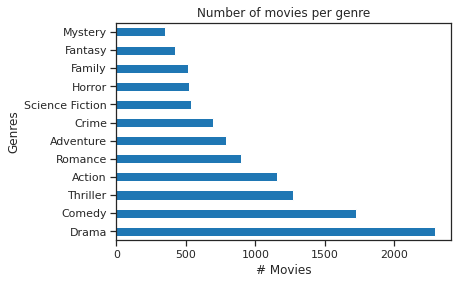

In [8]:
ax = df.iloc[:,1:].sum().sort_values(ascending=False).plot(kind='barh',
                                                           title='Number of movies per genre')
ax.set_xlabel("# Movies")
ax.set_ylabel("Genres")

### Number of genres per movie

count    4660.00
mean        2.40
std         1.06
min         1.00
25%         2.00
50%         2.00
75%         3.00
max         7.00
dtype: float64


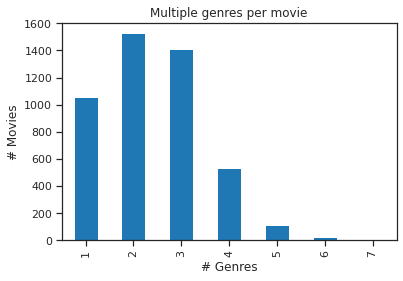

In [9]:
sum_df = df.iloc[:,1:].sum(axis=1)
ax = sum_df.value_counts().sort_index().plot(kind='bar', title='Multiple genres per movie')
ax.set_xlabel('# Genres')
ax.set_ylabel('# Movies')
print(sum_df.describe().round(2))

### Number of characters

count    4660.0
mean      304.1
std       159.9
min         1.0
25%       178.0
50%       284.0
75%       391.0
max      1000.0
Name: overview, dtype: float64


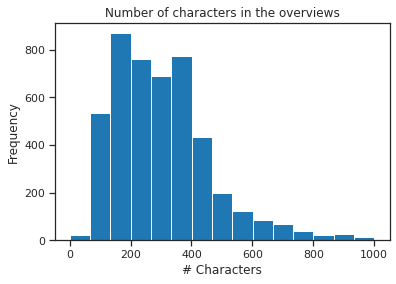

In [10]:
chr_lens = df.overview.str.len()
ax = chr_lens.plot(kind='hist', bins=15, title='Number of characters in the overviews')
ax.set_xlabel("# Characters")
print(chr_lens.describe().round(2))

### Number of words

count    4660.00
mean       51.99
std        27.44
min         2.00
25%        30.00
50%        48.00
75%        67.00
max       175.00
Name: overview, dtype: float64


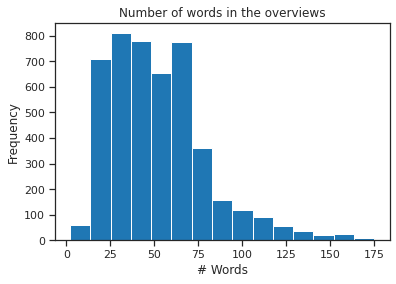

In [11]:
word_lens = df.overview.str.split(" ").str.len()
ax = word_lens.plot(kind='hist', bins=15, title='Number of words in the overviews')
ax.set_xlabel("# Words")
print(word_lens.describe().round(2))

### Word Cloud

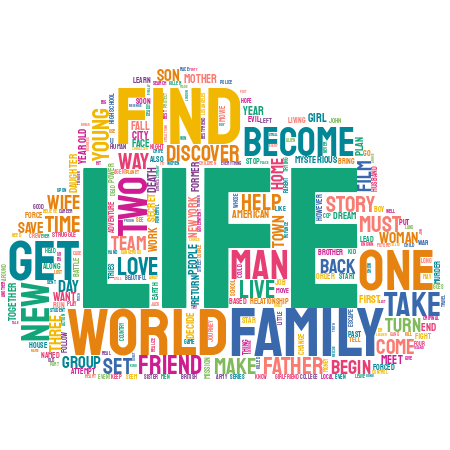

In [12]:
stop_words = set(stopwords.words('english')) # Stop words

stylecloud.gen_stylecloud(text = " ".join(df.overview.values), icon_name= "fas fa-cloud",
                          palette='cartocolors.qualitative.Bold_10',
                          background_color='white', custom_stopwords=stop_words,
                          random_state=9, size=(450,450),
                          output_name='word_cloud.png')
Image('./word_cloud.png')

Shape of the dataset:

In [13]:
df_final = df.copy()
df_final.shape

(4660, 13)

# Naive Bayes

### Normalize text
- Lower-case text.
- Replacing contractions.
- Cleaning up special characters.
- Removing extra whitespaces.
- Removing stopwords.
- Stemming.

In [14]:
porter = PorterStemmer() # Stemmer

def clean(text):
    text = text.lower() # To lower case
    # Replace contractions
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text) # Replace any character which is not a word character
    text = re.sub('\s+', ' ', text) # Replace any whitespace character
    text = re.sub(' +', ' ', text) # Replace multiple whitespaces
    text = text.strip() # Delete sorrounding whitespaces
    tokens = word_tokenize(text) # Tokenize text
    #  Delete Stop Words and apply stemming
    new_tokens = [porter.stem(word) for word in tokens if not word in stop_words] 
    text = (" ").join(new_tokens) # Join tokens
    return text

df_final['overview'] = df_final['overview'].progress_apply(lambda x: clean(x))

  0%|          | 0/4660 [00:00<?, ?it/s]

Example of the transformation:

In [15]:
print('Original: ' + df['overview'][5])
print(' ')
print('New: ' + df_final['overview'][5])

Original: The seemingly invincible Spider-Man goes up against an all-new crop of villain – including the shape-shifting Sandman. While Spider-Man’s superpowers are altered by an alien organism, his alter ego, Peter Parker, deals with nemesis Eddie Brock and also gets caught up in a love triangle.
 
New: seemingli invinc spider man goe new crop villain includ shape shift sandman spider man superpow alter alien organ alter ego peter parker deal nemesi eddi brock also get caught love triangl


Split in train (80%) and test (20%):

In [16]:
X = df_final.overview
y = df_final.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
print(X_train.shape)
print(X_test.shape)

(3728,)
(932,)


### TF-IDF
Apply Tf-Idf strategy to encode the overview:

In [17]:
# Ignore words that appear in less than 10 document and more than 80% of the documents
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.8, min_df=10)
X_train_enc = tfidf.fit_transform(X_train)
X_test_enc = tfidf.transform(X_test)

print('Vocabulary: ' + str(X_train_enc.shape[1]))
print(' ')
print('Original: ' + X_train[3])
print(' ')
print('Encoded: ' + str(X_train_enc[3]))

Vocabulary: 1998
 
Original: follow death district attorney harvey dent batman assum respons dent crime protect late attorney reput subsequ hunt gotham citi polic depart eight year later batman encount mysteri selina kyle villain bane new terrorist leader overwhelm gotham finest dark knight resurfac protect citi brand enemi
 
Encoded:   (0, 284)	0.22446153666179
  (0, 1339)	0.19611956108213768
  (0, 1980)	0.2700910624196864
  (0, 134)	0.23393504951992836
  (0, 315)	0.28999650344792005
  (0, 91)	0.2721398055734086
  (0, 516)	0.23136888472044098
  (0, 507)	0.2841157761370443
  (0, 1493)	0.2549877633045189
  (0, 883)	0.26813340520493745
  (0, 590)	0.185552125002688
  (0, 1338)	0.30061728906241525
  (0, 997)	0.17952484169701424
  (0, 1755)	0.17727868737331992
  (0, 735)	0.25223436454517495
  (0, 354)	0.24161357893067972
  (0, 760)	0.20903860913422861


### Naive Bayes Model
Naive Bayes with One vs Rest strategy for multilabel classification:

In [18]:
clf = OneVsRestClassifier(MultinomialNB())
clf.fit(X_train_enc, y_train)
y_pred_proba = clf.predict_proba(X_test_enc)
predictions = clf.predict(X_test_enc)

## Results

In [19]:
metrics = ['Ranking Average Precision', 'Ranking Loss', 'Exact Match Ratio', 'Recall', 'Precision', 'F1-Score']
results = pd.DataFrame(index=metrics)
results.index.name = 'Metrics'
results['Naive Bayes'] = 0
results['DistilBERT'] = 0

### Metrics

In [20]:
results.loc['Ranking Average Precision', 'Naive Bayes'] = sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba)
results.loc['Ranking Loss', 'Naive Bayes'] = sklearn.metrics.label_ranking_loss(y_test, y_pred_proba)
results.loc['Exact Match Ratio', 'Naive Bayes'] = sklearn.metrics.accuracy_score(y_test, predictions)
results.loc['Recall', 'Naive Bayes'] = sklearn.metrics.precision_score(y_test, y_pred=predictions, average='samples')
results.loc['Precision', 'Naive Bayes'] = sklearn.metrics.recall_score(y_test, y_pred=predictions, average='samples')
results.loc['F1-Score', 'Naive Bayes'] = sklearn.metrics.f1_score(y_test, y_pred=predictions, average='samples')
results = results.round(2)
results

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Naive Bayes,DistilBERT
Metrics,,
Ranking Average Precision,0.73,0
Ranking Loss,0.14,0
Exact Match Ratio,0.13,0
Recall,0.53,0
Precision,0.36,0
F1-Score,0.40,0


### Confusion Matrixes (as individual models)

Text(0.08, 0.5, 'Real value')

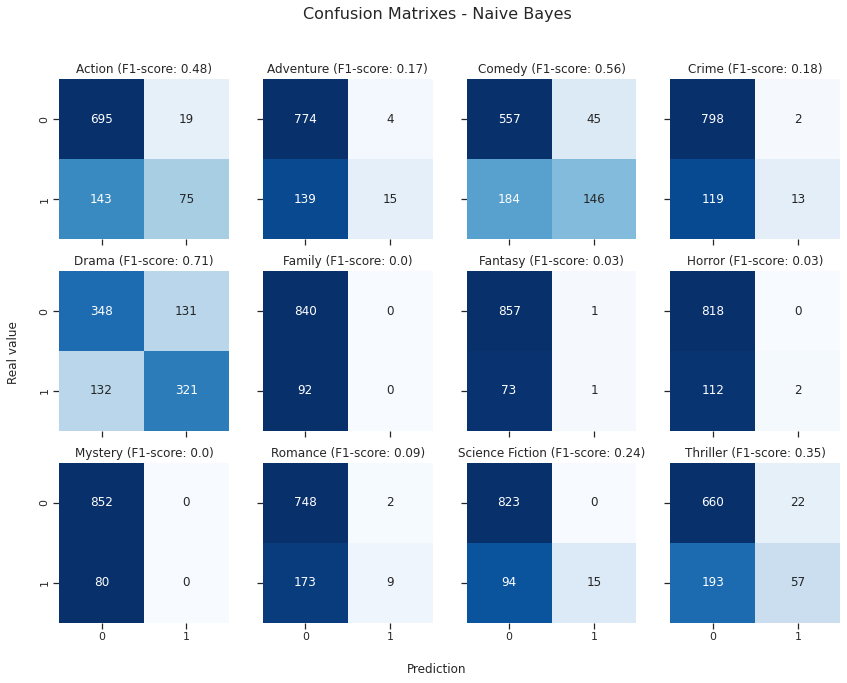

In [21]:
fig, axes = plt.subplots(3,4, figsize=(14, 10), sharey=True, sharex=True)
fig.suptitle('Confusion Matrixes - Naive Bayes', fontsize=16)

confusion_matrixes = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrixes):
    f1_score = sklearn.metrics.f1_score(y_test.iloc[:,idx], pd.DataFrame(predictions).iloc[:,idx])
    f1_score = round(f1_score,2)
    ax = axes.flat[idx]
    vmax = i[1,0] + i[1,1]
    sns.heatmap(i, annot=True, fmt='g', vmin=0, vmax=vmax, cmap="Blues", cbar=False,
                ax=ax).set_title(y_test.columns[idx] + ' (F1-score: ' + str(f1_score) + ')')

# Set common labels
fig.text(0.5, 0.06, 'Prediction', ha='center', va='center')
fig.text(0.08, 0.5, 'Real value', ha='center', va='center', rotation='vertical')

# DistilBERT

Split dataframe without normalization in train and test (with the same random state to be able to compare models):

In [22]:
X = df.overview
y = df.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

### Tokenize

Create tokenizer:

In [23]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Example applying tokenizer (It is applied at word level):

In [24]:
text = X_train.iloc[0]
encoded_input = tokenizer(text)

print('Original: '+ text)
print(' ')
print('Tokens: ' + str(encoded_input))
print(' ')
print('Reverse tokens: ' + tokenizer.decode(encoded_input["input_ids"]))

Original: Special Agent Strahm is dead, and Detective Hoffman has emerged as the unchallenged successor to Jigsaw's legacy. However, when the FBI draws closer to Hoffman, he is forced to set a game into motion, and Jigsaw's grand scheme is finally understood.
 
Tokens: {'input_ids': [101, 2569, 4005, 2358, 10404, 2213, 2003, 2757, 1010, 1998, 6317, 15107, 2038, 6003, 2004, 1996, 4895, 18598, 7770, 5999, 6332, 2000, 10147, 5620, 10376, 1005, 1055, 8027, 1012, 2174, 1010, 2043, 1996, 8495, 9891, 3553, 2000, 15107, 1010, 2002, 2003, 3140, 2000, 2275, 1037, 2208, 2046, 4367, 1010, 1998, 10147, 5620, 10376, 1005, 1055, 2882, 5679, 2003, 2633, 5319, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
 
Reverse tokens: [CLS] special agent strahm is dead, and detective hoffman has emerged as the unchallenged successor to jigsaw's 

Apply tokenizer to train and test, returning tensors for the neural network

In [25]:
# Train
batch_sentences = X_train.values.tolist()
X_train = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="tf")
X_train['targets'] = np.array(y_train)
max_length = X_train['input_ids'].shape[1]

# Test
batch_sentences = X_test.values.tolist()
X_test = tokenizer(batch_sentences, padding='max_length', max_length=max_length, 
                   truncation=True, return_tensors="tf")
X_test['targets'] = np.array(y_test)

print(X_train)

{'input_ids': <tf.Tensor: shape=(3728, 225), dtype=int32, numpy=
array([[ 101, 2569, 4005, ...,    0,    0,    0],
       [ 101, 2275, 1999, ...,    0,    0,    0],
       [ 101, 1037, 2732, ...,    0,    0,    0],
       ...,
       [ 101, 1996, 4251, ...,    0,    0,    0],
       [ 101, 1999, 3381, ...,    0,    0,    0],
       [ 101, 8057, 1010, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3728, 225), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'targets': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])}


### DistilBERT Neural Network

Load the model

In [26]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              num_labels=len(y_train.columns), 
                                                              problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-01-29 18:38:06.501592: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint 

Create tensorflow datasets and batches

In [27]:
train_features = {x: X_train[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, X_train["targets"]))
train_tf_dataset = train_tf_dataset.shuffle(len(X_train)).batch(32)

test_features = {x: X_test[x] for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, X_test["targets"]))
test_tf_dataset = test_tf_dataset.batch(32)

Train the neural network:

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Optimize individual binary crossentropy
    metrics=tf.keras.metrics.BinaryAccuracy()
)

model.fit(train_tf_dataset, validation_data=test_tf_dataset, epochs=3)

Epoch 1/3
117/117 [==============================] - 66s 473ms/step - loss: 0.4306 - binary_accuracy: 0.8122 - val_loss: 0.3438 - val_binary_accuracy: 0.8385
Epoch 2/3
117/117 [==============================] - 54s 462ms/step - loss: 0.3112 - binary_accuracy: 0.8560 - val_loss: 0.3103 - val_binary_accuracy: 0.8633
Epoch 3/3
117/117 [==============================] - 54s 463ms/step - loss: 0.2476 - binary_accuracy: 0.8917 - val_loss: 0.3173 - val_binary_accuracy: 0.8671


### Logits to probabilities and to labels

Probability of 0.5 corresponds to a logit of 0. Negative logit correspond to probabilities less than 0.5, positive to > 0.5.

In [29]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

y_pred_logits = model.predict(test_tf_dataset)
y_pred_proba = inv_logit(y_pred_logits[0])

predictions = pd.DataFrame(y_pred_proba, columns=y_test.columns, index=y_test.index).copy()
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

## Results

### Metrics

In [30]:
results.loc['Ranking Average Precision', 'DistilBERT'] = sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba)
results.loc['Ranking Loss', 'DistilBERT'] = sklearn.metrics.label_ranking_loss(y_test, y_pred_proba)
results.loc['Exact Match Ratio', 'DistilBERT'] = sklearn.metrics.accuracy_score(y_test, predictions)
results.loc['Recall', 'DistilBERT'] = sklearn.metrics.precision_score(y_test, y_pred=predictions, average='samples')
results.loc['Precision', 'DistilBERT'] = sklearn.metrics.recall_score(y_test, y_pred=predictions, average='samples')
results.loc['F1-Score', 'DistilBERT'] = sklearn.metrics.f1_score(y_test, y_pred=predictions, average='samples')
results = results.round(2)
results

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Naive Bayes,DistilBERT
Metrics,,
Ranking Average Precision,0.73,0.79
Ranking Loss,0.14,0.10
Exact Match Ratio,0.13,0.22
Recall,0.53,0.71
Precision,0.36,0.65
F1-Score,0.40,0.64


### Confusion Matrixes (as individual models)

Text(0.08, 0.5, 'Real value')

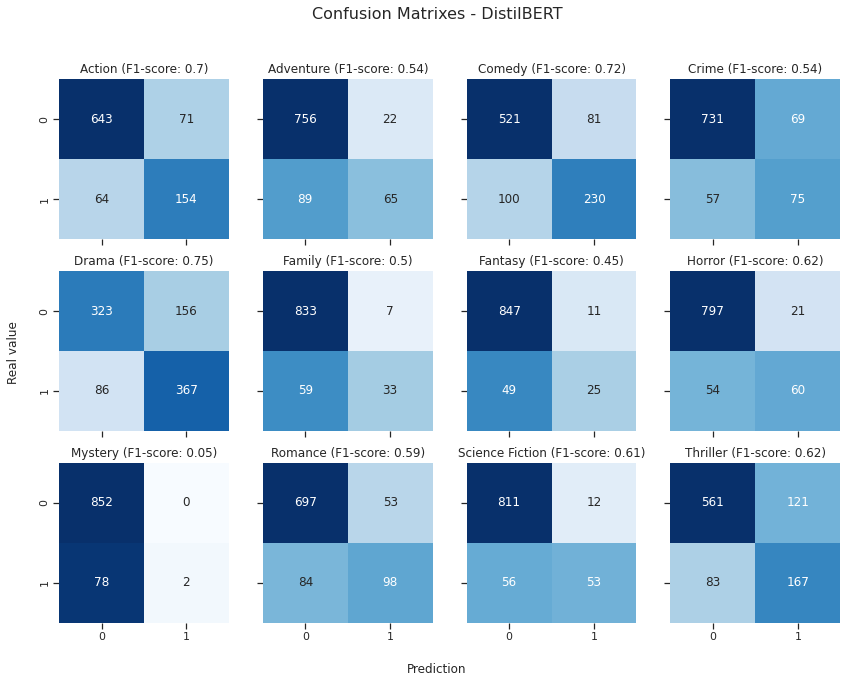

In [31]:
fig, axes = plt.subplots(3,4, figsize=(14, 10), sharey=True, sharex=True)
fig.suptitle('Confusion Matrixes - DistilBERT', fontsize=16)

confusion_matrixes = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrixes):
    f1_score = sklearn.metrics.f1_score(y_test.iloc[:,idx], predictions.iloc[:,idx])
    f1_score = round(f1_score,2)
    ax = axes.flat[idx]
    vmax = i[1,0] + i[1,1]
    sns.heatmap(i, annot=True, fmt='g', vmin=0, vmax=vmax, cmap="Blues", cbar=False,
                ax=ax).set_title(y_test.columns[idx] + ' (F1-score: ' + str(f1_score) + ')')

# Set common labels
fig.text(0.5, 0.06, 'Prediction', ha='center', va='center')
fig.text(0.08, 0.5, 'Real value', ha='center', va='center', rotation='vertical')